In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from sklearn import metrics
from sklearn import preprocessing

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [12]:
import os
from sys import argv
import pdb

In [13]:
def get_data(data_dir):
    fs = [data_dir + f for f in os.listdir(data_dir) if ('signal' in f or 'WZ' in f) and f[0] != '.']
    df = pd.DataFrame()

    for f in fs:
        print f
        new_df = pd.read_csv(f)
        df = pd.concat([df, new_df], ignore_index = True)
        df.index = range(len(df))

    return df

In [14]:
def add_cl_ix(df):
    df['is_sig'] = [1 if 'signal' in val else 0 for val in df.cl.values]
    return df

In [15]:
class WWdataset(Dataset):

    def __init__(self, pd_dataset):
        self.dataset = pd_dataset

        self.input_vars = [col for col in self.dataset.columns if not col in ['runNumber', 'lbNumber', 'eventNumber', 'SFOS', 'is_sig', 'weight', 'cl', 'preds']]

        self.target_var = ['is_sig']
        self.weight_var = ['weight']

        self.input_np = self.dataset[self.input_vars].as_matrix().astype(dtype=np.float32)
        self.target_np = self.dataset[self.target_var].as_matrix().astype(dtype=int)
        self.weight_np =self.dataset[self.weight_var].as_matrix().astype(dtype=np.float32)

        self.inputs = torch.from_numpy(self.input_np)
        self.target = torch.from_numpy(self.target_np)
        self.weight = torch.from_numpy(self.weight_np)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        inputs = self.inputs[idx]
        target = self.target[idx]
        weight = self.weight[idx]
        return inputs, target, weight

    def n_input(self):
        return len(self.input_vars)
    
    def scale_dataset(self):
        # developing
        for target_value in [0, 1]:
            pass

In [16]:
def net_logistic_regression(n_input):
    model = torch.nn.Sequential(
        torch.nn.Linear(n_input, 2),
    )
    return model

In [17]:
def net_deep_logistic_regression(n_input):
    model = torch.nn.Sequential(
        torch.nn.Linear(n_input, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 2),
    )
    return model

In [20]:
data_dir = "../../data/"
pandas_dataset = add_cl_ix(get_data(data_dir))

in_dataset = WWdataset(pandas_dataset)
trainloader = torch.utils.data.DataLoader(in_dataset, batch_size=200, shuffle=True, num_workers=2)

../../data/bkg_WZqqll.csv
../../data/signal_WmWpWm.csv
../../data/bkg_WZlvll.csv
../../data/signal_WpWpWm.csv


In [21]:
#net = net_logistic_regression(in_dataset.n_input())
net = net_deep_logistic_regression(in_dataset.n_input())
criterion = nn.CrossEntropyLoss(reduce=False)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

# Training

In [22]:
for epoch in range(5):
        print
        print "epoch: ", epoch
        running_loss = 0.
        for i, data in enumerate(trainloader):
            inputs, label, weight = data
            inputs, label, weight = Variable(inputs), Variable(label), Variable(weight)

            optimizer.zero_grad()
            output = net(inputs)
            losses = criterion(output, label.squeeze())
            loss = (losses * weight.squeeze()).sum()
            loss.backward()
            optimizer.step()

            running_loss += loss.data[0]
            if i % 200 == 199:    # print every 2000 mini-batches
                print "batch:  {}, loss: {}".format(i+1, running_loss/(i+1))


epoch:  0
batch:  200, loss: 0.147117652297
batch:  400, loss: 0.125536965504
batch:  600, loss: 0.117212351784
batch:  800, loss: 0.111387496591
batch:  1000, loss: 0.108573903337
batch:  1200, loss: 0.105190123636
batch:  1400, loss: 0.102270311639
batch:  1600, loss: 0.0999804490712
batch:  1800, loss: 0.0987248577033
batch:  2000, loss: 0.0973260268029
batch:  2200, loss: 0.0961176706173
batch:  2400, loss: 0.095056086566
batch:  2600, loss: 0.0947417830361
batch:  2800, loss: 0.0939744775423
batch:  3000, loss: 0.0932223996557
batch:  3200, loss: 0.0929775172588
batch:  3400, loss: 0.0927156185775

epoch:  1
batch:  200, loss: 0.0830659084581
batch:  400, loss: 0.0826538301352
batch:  600, loss: 0.0821997235032
batch:  800, loss: 0.0822846028255
batch:  1000, loss: 0.0852944866978
batch:  1200, loss: 0.0855045397052
batch:  1400, loss: 0.0854182330652
batch:  1600, loss: 0.0849185288209
batch:  1800, loss: 0.0846304851294
batch:  2000, loss: 0.0844289225824
batch:  2200, loss: 0.

# Prediction

In [23]:
input_for_pred = Variable(in_dataset.inputs)
predicted_scores = net(input_for_pred)
predicted_prob = nn.functional.softmax(predicted_scores, dim=1)

In [24]:
pandas_dataset['preds'] = predicted_prob.data.numpy()[:,1]

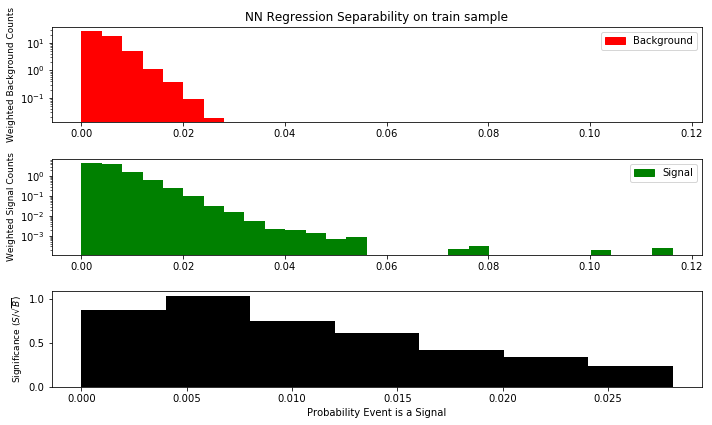

In [54]:
df = pandas_dataset
df = df[df['SFOS'] == 0] 

x_bins = np.linspace(0, max(df.preds), 30)
fig = plt.figure(figsize=(10,6))
gs = gridspec.GridSpec(3, 1)
ax = plt.subplot(gs[0,:])
plt.title('NN Regression Separability on train sample')
# n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds, bins=x_bins, weights=df[df.is_sig == 0].weight, color='r')
n_bkg,bins,paint = plt.hist(df[df.is_sig == 0].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 0].weight.as_matrix(), color='r')
plt.yscale('log')
plt.ylabel(r'Weighted Background Counts', size=9)
plt.legend(handles=[mpatches.Patch(color='red', label='Background')])
ax1 = plt.subplot(gs[1,:])
n_sig,bins,paint = plt.hist(df[df.is_sig == 1].preds.as_matrix(), bins=x_bins, weights=df[df.is_sig == 1].weight.as_matrix(), color='g')
plt.yscale('log')
plt.ylabel(r'Weighted Signal Counts', size=9)
plt.legend(handles=[mpatches.Patch(color='green', label='Signal')])
ax2 = plt.subplot(gs[2,:])
plt.bar((x_bins[:-1] + x_bins[1:]) / 2., n_sig / np.sqrt(n_bkg), width=x_bins[1] - x_bins[0], color='k')
plt.ylabel(r'Significance ($S/\sqrt{B})$', size=9)
plt.xlabel('Probability Event is a Signal')

plt.tight_layout()
plt.show()
# plt.savefig("./plots/preds_train_nn_regression.pdf")

In [25]:
df = pandas_dataset

fpr, tpr, thresholds = metrics.roc_curve(df.is_sig.values, df.preds.values, pos_label=1)
fig = plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.title('NN Regression ROC')
plt.annotate('Area: ' + str(round(metrics.auc(fpr, tpr), 2)), xy=(.8,.2), xycoords='axes fraction')
plt.xlim((0,1))
plt.ylim((0,1))
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show
plt.savefig("./plots/roc_curve_train_nn_regression.pdf")

In [37]:
df[df.is_sig == 1].weight.sum()/np.sqrt(df[df.is_sig == 0].weight.sum())

0.5173087712083756

# Developing

In [55]:
# https://github.com/tongbaojia/MakePlot/blob/master/get_count.py#L780
# sensitivity = ROOT.TMath.Sqrt(2 * ((S + B) * ROOT.TMath.Log(1 + S / B) - S))
# sensitivity_err = (ROOT.TMath.Log(1 + S / B) * S_err + (ROOT.TMath.Log(1 + S / B) - S / B) * B_err) / sensitivity

